In [1]:
import os
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "tensorflow"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from functools import partial

np.set_printoptions(suppress=True)

In [3]:
from boundary_conditions import bound_agent_position

In [4]:
import keras

import bayesflow as bf

INFO:bayesflow:Using backend 'tensorflow'


In [5]:
# As far as I know, Numba cannot be used
# from numba import njit

## Generative Model Definition

The movement of any agent $a = 1, ..., A$ is both related to: 1) its interaction with surrounding neighbors $i = 1, ..., I$, which we call *internal influence*, and 2) their motivation to the surrounding spatial objects $b = 1, ..., B$, which we call *external influence*. These influences are modulated by a stationary weight, $w_a$:

\begin{equation}
    \theta_{a, t} = w_a \theta_{a|j, t} + (1 - w_a) \theta_{a|i, t}.
\end{equation}

### Meta-Variables

First, we define some meta-variables, such as the number of agents to simulate, the number of spatial beacons present in the environment, etc.

In [6]:
num_agents = 12
num_beacons = 2
room_size = (8., 10.)
world_size = 25.

### Agent Initialization

In [7]:
def initialize_agents(
    num_agents: int = 12,
    room_size: tuple = (8., 10.),
):
    """
    Generate random positions and orientations for agents.

    Parameters
    ----------
    num_agents : int, optional
        Number of agents to generate (default is 100).
    room_size : float, optional
        The size of the boundary within which positions are generated (default is 100.0).

    Returns
    -------
    tuple of np.ndarray
        A tuple containing the positions (np.ndarray) and orientations (np.ndarray) of the agents.
    """

    # Generate random positions within the boundary size centered at 0
    x = (np.random.random(size=num_agents).astype(np.float32) - 0.5) * room_size[0]
    y = (np.random.random(size=num_agents).astype(np.float32) - 0.5) * room_size[1]
    positions = np.vstack((x, y)).T

    # Generate random orientations (angles in radians between 0 and 2*pi)
    rotations = np.random.random(size=(num_agents, )).astype(np.float32) * np.pi * 2

    return positions.astype(np.float32), rotations.astype(np.float32)

In [8]:
agent_positions, agent_rotations = initialize_agents(room_size=room_size, num_agents=12)
agent_positions[0]

array([1.7448397, 2.8740354], dtype=float32)

### Beacon Initialization

In [9]:
def initialize_beacons(
        num_beacons = 10,
        room_sensing_range = 50.
):

    """
    Initialize beacons following a uniform distribution scaled to the room's sensing boundary

    Parameters
    ----------
    num_beacons : int, default: 10
        Number of beacons to initialize.
    room_sensing_range : float, default: 50.0
        Sensing distance of the room for the beacons to matter.

    Returns
    -------
    beacons      : np.ndarray of shape (num_beacons, 2)
        Initial positions of the beacons.
    """

    beacons = (np.random.random(size=(num_beacons, 2)) - 0.5) * room_sensing_range
    return beacons.astype(np.float32)

In [10]:
beacon_positions = initialize_beacons(num_beacons=1, room_sensing_range=world_size)
beacon_positions

array([[-7.7377133,  7.6874027]], dtype=float32)

## External Influence: drift-diffusion vector

We want to compute the influence of agent movement direction within a single time step. For this, we specify our internal influence as a 2D drift diffusion model, where the agents are approach a spatial beacon within the room's boundary by reorienting its locomotive direction.

\begin{equation}
    \theta_{a|j, t} = \theta_{a|j, t-1} + \omega_a \mathrm{d}t + \mathrm{d}\phi_t,
\end{equation}

\begin{align}
    \mathrm{d}\mathbf{x}_{a|j, t}
    &= v_{a|j}\mathrm{d}t \frac{\mathbf{x}_{a|j}}{||\mathbf{x}_{a|j}||} + \sigma_{a|j} \mathrm{d}\mathrm{W}_t \\
    &= v_{a}\mathrm{d}t
    \begin{bmatrix}
        \cos \theta_{a|j, t} \\
        \sin \theta_{a|j, t}
    \end{bmatrix} + \sigma_{a|j} \mathrm{d}\mathrm{W}_t,% \sqrt{\mathrm{d}t} Z_t.
\end{align}

In [11]:
def external_influence(
    agent_position,
    beacon_position,
    noise = False,
    noise_amplitude = 0.01
):
    """
    Generate a drift-diffusion vector in 2D space for a single agent
    based on a target location (in this case, the position of a beacon).

    Parameters
    ----------
    agent_position : np.ndarray
        The position of the agent.
    target_position : np.ndarray
        The position of the target beacon.
    focus : float, optional
        The dispersion of a von Mises distribution for rotational noise influenced by the neighbors.
        The higher the value is, the less perturbation there would be.
    noise: bool, optional
        Whether the focus is interpreted as noise amplitude.

    Returns
    -------
    np.ndarray
        A 2D vector representing the drift-diffusion process towards the target (beacon).
    """
    # Calculate the angle towards the beacon (in radian)
    beacon_direction = np.arctan2(
        beacon_position[1] - agent_position[1],
        beacon_position[0] - agent_position[0]
    )

    # Generate a random direction with drift around the target angle
    if noise:
        beacon_direction = beacon_direction + (np.random.random() - 0.5) * noise_amplitude
        # beacon_direction = beacon_direction + np.random.vonmises(0., 8.) * noise_amplitude

    # Convert the angle to a unit vector in 2D space
    v = np.array([np.cos(beacon_direction), np.sin(beacon_direction)], dtype=np.float32)

    return v

## Internal Influence: particle dynamics

Its influence by a collective group of agents is modeled as a self-propelling particle system, as expressed in the Vicsek model:

\begin{align}
    \theta_{a|i, t} &= \langle \theta_{i, t}\rangle_{|\mathbf{x}_a - \mathbf{x}_i| < r_a, i \in I} + \eta_{a,t-1}, \\
    \mathrm{d} \mathbf{x}_{a|i,t} &= v_{a,t} \mathrm{d}t
    \begin{bmatrix}
        \cos \theta_{a|i, t} \\
        \sin \theta_{a|i, t}
    \end{bmatrix},
\end{align}

In [12]:
def internal_influence(
        self_position,
        other_positions,
        other_rotations,
        sensing_radius = 1.5,
        focus = 0.01,
        noise = False
):
    """
    Generate an influence vector for a single agent
    based on the angular component of the Vicsek model.

    Parameters
    ----------
    self_position : np.ndarray of shape (2,)
        A 2D vector representing the position of the agent
    other_positions : np.ndarray of shape (2,)
        A 2D vector representing the positions of the neighboring agents.
    other_rotations : np.ndarray of shape (2,)
        A 2D vector representing the rotations of the neighboring agents.
    sensing_radius : float
        The sensing radius within which agents interact with their neighbors.
    focus : float, optional
        The dispersion of a von Mises distribution for rotational noise influenced by the neighbors.
        The higher the value is, the less perturbation there would be.
    noise: bool, optional
        Whether the focus is interpreted as noise amplitude.

    Returns
    -------
    np.ndarray
        A 2D unit vector representing the averaged influence direction with added noise.
    """

    neighbor_rotations = []

    for i in range(len(other_positions)):
        dx = other_positions[i, 0] - self_position[0]
        dy = other_positions[i, 1] - self_position[1]
        d = (dx ** 2 + dy ** 2) ** 0.5

        if d <= sensing_radius and d > 0:
            neighbor_rotations.append(other_rotations[i])

    if len(neighbor_rotations) == 0:
        return np.array([0.0, 0.0], dtype=np.float32)

    neighbor_rotations = np.array(neighbor_rotations)
    averaged_rotation = np.sum(neighbor_rotations) / len(neighbor_rotations)

    if noise:
        deviation = (np.random.random() - 0.5) * focus
    else:
        deviation = np.random.vonmises(mu=0., kappa=4.) * focus
    direction = averaged_rotation + deviation

    v = np.array([np.cos(direction), np.sin(direction)], dtype=np.float32)

    return v

## Putting everything together: combined influences

The combined influences allow us to update the agents' positions and rotations together.

In [13]:
def count_neighbors(self_position, other_positions, sensing_radius = 1.5):
    """
    Helper function that counts the number of neighbors

    Parameters
    ----------
    self_position   : np.ndarray of size (2)
        The position of the agent itself
    other_positions : np.ndarray of size (num_agents, 2)
        The positions of all agents
    sensing_radius  : float, default: 1.5
        The sensing radius of the agent

    Returns
    -------
    num_neighbors   : int, default: 0
        The number of neighbors within the agent's sensing radius.
    """

    num_neighbors = 0

    for i in range(len(other_positions)):
        dx = other_positions[i, 0] - self_position[0]
        dy = other_positions[i, 1] - self_position[1]
        d = (dx ** 2 + dy ** 2) ** 0.5

        if d <= sensing_radius and d > 0:
            num_neighbors += 1

    return num_neighbors

In [14]:
num_neighbors = count_neighbors(agent_positions[8], agent_positions)
num_neighbors

1

In [15]:
def combined_influences(
    agent_positions: np.ndarray = None,
    agent_rotations: np.ndarray = None,
    beacon_positions: np.ndarray = None,
    velocity: float = 1.0,
    sensing_radius: float = 2.5,
    dt: float = 0.1,
    influence_weight: float = 0.5,
    internal_focus: float = 0.1
):
    """
    Update the positions and orientations of a single agent
    based on velocity and influence vectors.

    Parameters
    ----------
    agent_positions : np.ndarray
        Current positions of the agents.
    agent_rotations : np.ndarray
        Current orientations of the agents.
    beacon_positions : np.ndarray
        Positions of the beacons.
    velocity : float, optional
        The speed at which agents move (default is 1.0).
    sensing_radius : float, optional
        The sensing radius within which agents interact with their neighbors.
    dt : float, optional
        The time step for updating positions and orientations (default is 0.1).
    influence_weight : float, optional
        The weight of influence_vector1 in determining new orientations (default is 0.7).
    external_focus : float, optional
        Concentration of the agent's rotational noise influenced by the beacons
    internal_focus : float, optional
        Concentration of the agent's rotational noise influenced by the neighbors

    Returns
    -------
    tuple of np.ndarray
        Updated positions (np.ndarray) and orientations (np.ndarray) of the agents.
    """

    assert (len(agent_positions) == len(agent_rotations))

    num_agents = agent_positions.shape[0]
    num_beacons = beacon_positions.shape[0]

    # Create new numpy arrays for the updated agent positions and rotations
    new_agent_positions = np.zeros((num_agents, 2))
    new_agent_rotations = np.zeros((num_agents, ))
    num_neighbors = np.zeros((num_agents, ))


    for i in range(num_agents):

        num_neighbors[i] = count_neighbors(agent_positions[i], agent_positions)

        # Generate the ddm vector for the agent based on its closest beacon
        distance_to_beacon = []

        for b in range(num_beacons):
            bx = beacon_positions[b, 0] - agent_positions[i, 0]
            by = beacon_positions[b, 1] - agent_positions[i, 1]
            distance_to_beacon.append((bx * bx + by * by) ** 0.5)

        beacon_id = np.argmin(np.array(distance_to_beacon))

        ddm_vector = external_influence(
            agent_positions[i],
            beacon_positions[beacon_id],
            #focus=external_focus
        )

        # Generate the vicsek vector for the agent based on its neighbors (all agents)
        vicsek_vector = internal_influence(
            self_position=agent_positions[i],
            other_positions=agent_positions,
            other_rotations=agent_rotations,
            sensing_radius=sensing_radius,
            focus=internal_focus
        )

        # Update orientations based on two influence vectors
        ddm_influence = np.arctan2(ddm_vector[1], ddm_vector[0])
        vicsek_influence = np.arctan2(vicsek_vector[1], vicsek_vector[0])

        # Combine influences to update orientations with different weights
        new_agent_rotations[i] = agent_rotations[i] + (influence_weight * ddm_influence + (1 - influence_weight) * vicsek_influence) * dt

        # Ensure orientations are within the range [0, 2*pi]
        new_agent_rotations[i] = np.mod(new_agent_rotations[i], 2 * np.pi)

        # Update positions based on current orientations
        new_agent_positions[i, 0] = agent_positions[i, 0] + velocity * np.cos(new_agent_rotations[i].item()) * dt
        new_agent_positions[i, 1] = agent_positions[i, 1] + velocity * np.sin(new_agent_rotations[i].item()) * dt

        new_agent_positions[i] = bound_agent_position(new_agent_positions[i], room_size=room_size)

    return new_agent_positions, new_agent_rotations, num_neighbors

In [16]:
agent_positions, agent_rotations = initialize_agents(12, room_size=room_size)
beacon_positions = initialize_beacons(num_beacons=2)
new_agent_positions, new_agent_rotations, num_neighbors = combined_influences(agent_positions, agent_rotations, beacon_positions)

In [17]:
np.concatenate([agent_positions, new_agent_positions], axis=1)

array([[ 0.52777195,  1.8755722 ,  0.47879451,  1.96275713],
       [-0.75915217, -0.13827354, -0.8544591 , -0.10799832],
       [ 1.23642159, -4.06857395,  1.32386227, -4.1170933 ],
       [-0.24189854,  2.24508238, -0.22932493,  2.34428875],
       [-2.62722397,  2.20944691, -2.70857234,  2.26760567],
       [ 0.45569086, -4.53195953,  0.42902384, -4.62833832],
       [-2.68190432,  0.11350274, -2.5828818 ,  0.09955492],
       [ 3.19812536, -0.23577958,  3.0985981 , -0.22606748],
       [ 0.76414108,  3.79125166,  0.78290946,  3.69302871],
       [ 0.20055532, -3.33235931,  0.14255311, -3.25089925],
       [-1.61876726,  4.82627821, -1.61433829,  4.72637634],
       [-3.49128389, -4.62007475, -3.55339788, -4.69844472]])

In [18]:
np.vstack([agent_rotations, new_agent_rotations]).T

array([[2.30850577, 2.08262727],
       [3.04219413, 2.83401358],
       [5.99008894, 5.77660093],
       [1.66652465, 1.44472658],
       [2.70275617, 2.52091362],
       [4.6115675 , 4.44245249],
       [6.05885839, 6.14325085],
       [3.12550497, 3.04431826],
       [4.87390375, 4.90119246],
       [2.30699277, 2.18955225],
       [4.82217455, 4.75669323],
       [4.08271885, 4.04219266]])

In [19]:
num_neighbors

array([1., 0., 2., 1., 0., 2., 0., 0., 0., 2., 0., 0.])

## Simulation Loop

The update allows us to continuously simulate the agents' positions and rotations at a given interval

In [20]:
def simulator_fun(
    theta = None,
    num_agents: int = 12,
    num_beacons: int = 1,
    room_size: tuple = (8, 10),
    velocity: float = 1.0,
    dt: float = 0.001,
    influence_weight: float = 0.7,
    sensing_radius: float = 10.0,
    internal_focus: float = 0.1,
    time_horizon: float = 30.
):
    """
    Run the simulation and store the time series of positions and orientations of agents.

    Parameters
    ----------
    theta : np.ndarray
        Prior parameters specifying the internal properties of the agents
    num_agents : int, optional
        Number of agents to generate (default is 100).
    num_beacons : int, optional
        Number of beacons to generate (default is 1).
    room_size : float, optional
        The size of the boundary within which positions are generated (default is 100).
    velocity : float, optional
        The speed at which agents move (default is 1.0).
    dt : float, optional
        The time step for the update (default is 0.1).
    influence_weight : float, optional
        The weight for influence_vector1 in determining new orientations (default is 0.7).
    sensing_radius : float, optional
        The sensing radius for the Vicsek model (default is 10.0).
    num_timesteps : int, optional
        The number of steps to simulate (default is 100).

    Returns
    -------
    tuple of np.ndarray
        The time series of positions and orientations of the agents.
    """

    if theta is not None:
        influence_weight = theta[0]
        sensing_radius = theta[1]
        velocity = theta[2]
        #internal_focus = theta[3]


    num_timesteps = int(time_horizon / dt)

    # Apply radial bound with sigmoid transformation for the sensing radius
    # (r_min, r_max) = (1., 5.)
    # sensing_radius = r_min + (r_max - r_min) * (1. / (1. + np.exp(-sensing_radius)))

    # Initialize positions and orientations
    initial_positions, initial_rotations = initialize_agents(num_agents, room_size=room_size)

    # Initialize arrays to store time series of positions and orientations
    positions = np.zeros((num_timesteps, num_agents, 2))
    rotations = np.zeros((num_timesteps, num_agents, ))
    neighbors = np.zeros((num_timesteps, num_agents, ))
    positions[0] = initial_positions
    rotations[0] = initial_rotations

    # Initialize beacons
    beacon_positions = initialize_beacons(num_beacons)

    # Simulation loop
    for t in range(1, num_timesteps):
        ps, rs, num_neighbors = combined_influences(
            agent_positions=positions[t-1],
            agent_rotations=rotations[t-1],
            beacon_positions=beacon_positions,
            velocity=velocity,
            sensing_radius=sensing_radius,
            dt=dt,
            influence_weight=influence_weight,
            internal_focus=internal_focus
        )

        # Store positions and orientations for each time step
        positions[t] = ps
        rotations[t] = rs
        neighbors[t] = num_neighbors

    neighbors[0] = neighbors[1]

    rotations = rotations[:,:,np.newaxis]
    neighbors = neighbors[:,:,np.newaxis]

    # return np.concatenate((positions, rotations, neighbors), axis=-1)
    return dict(
        positions=positions,
        rotations=rotations,
        neighbors=neighbors
    )

In [21]:
simulation = simulator_fun(num_agents=49)

In [22]:
print(simulation['positions'].shape)
print(simulation['rotations'].shape)
print(simulation['neighbors'].shape)

(30000, 49, 2)
(30000, 49, 1)
(30000, 49, 1)


### Priors

In [23]:
def prior_fun():
    weight = np.random.beta(2, 2)
    radius = np.random.gamma(5, 1)
    v = np.random.beta(2, 2) * 2.
    #focus = np.random.beta(2, 5)
    return {"w": weight, "r": radius, "v": v}

In [24]:
theta = prior_fun()
theta['w']

0.9098471467133625

In [25]:
simulator = bf.make_simulator([prior_fun, simulator_fun])

In [26]:
simulator.sample(1)

{'w': array([[0.43134128]]),
 'r': array([[11.32109287]]),
 'v': array([[0.07871468]]),
 'positions': array([[[[  2.84511185,   0.03266394],
          [ -1.76991057,  -0.59853107],
          [  0.91232634,  -1.98190475],
          ...,
          [  1.58007526,   1.20747328],
          [ -2.58071184,   4.14224625],
          [  2.04509068,   4.52865219]],
 
         [[  2.84610721,   0.0327601 ],
          [ -1.77043446,  -0.59938285],
          [  0.91328092,  -1.98220268],
          ...,
          [  1.58104157,   1.20773067],
          [ -2.58027522,   4.14314589],
          [  2.04492553,   4.52766592]],
 
         [[  2.84710265,   0.03285552],
          [ -1.77095899,  -0.60023425],
          [  0.91423524,  -1.98250147],
          ...,
          [  1.58200806,   1.20798739],
          [ -2.57983813,   4.14404531],
          [  2.04475964,   4.52667978]],
 
         ...,
 
         [[149.66056697,   1.23412451],
          [ -0.7515738 ,  -4.3127016 ],
          [  3.59406313,  -4.

In [27]:
prior_samples = simulator.simulators[0].sample(1000)

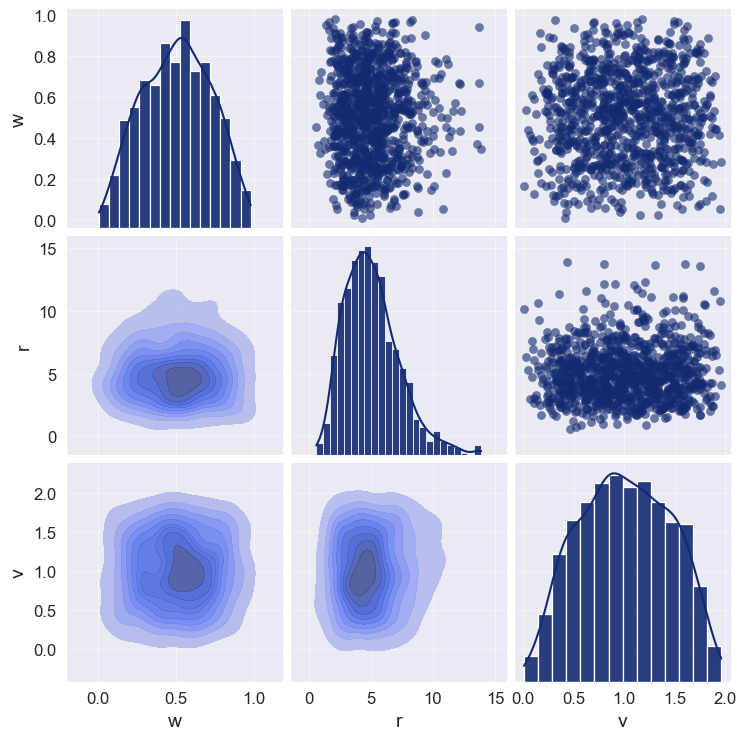

In [28]:
grid = bf.diagnostics.plots.pairs_samples(
    prior_samples, variable_keys=["w", "r", "v"]
)

### Adapter

In [35]:
adapter = (
    bf.adapters.Adapter()
    .convert_dtype("float64", "float32")
    .as_time_series(["positions", "rotations", "neighbors"])
    .concatenate(['w', 'r', 'v'], into="inference_variables")
    .concatenate(["positions", "rotations", "neighbors"], into="summary_variables")
)

In [36]:
adapter_sim = adapter(simulator.sample(2))

### Neural Approximator

In [39]:
# How do we go about the summary network, since HierarchicalNetwork has not been implemented yet?

# Need to ask Stefan about this.
summary_net = bf.networks.TimeSeriesTransformer()

In [38]:
inference_net = bf.networks.FlowMatching()

In [40]:
workflow = bf.workflows.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=inference_net,
    summary_network=summary_net
)